## Portfolio de Valores Eigen 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1153505  
Avellaneda-Lee 2008 - ideia original - Arbitragem Estatistica

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3070416  
Guo et. al 2017 - Alocação de Portfólio

O algoritmo retorna pesos positivos e negativos, isso siginifica que para realizar a alocação como sai do algoritmo, o alocador deve realizar vendas descobertas de alguns dos ativos e também os pesos são muito extremos 
Num contexto de um fundo long-only isso não é possivel, entretanto, realizei estudos zerando os pesos negativos e normalizando os pesos, para que a soma dos pesos seja igual a 1, assim evitando alavancagem, nos portfólios de MPT e EW, essa restrição é realizada no otimizador.
  
  
Esses pesos negativos podem servir de dados de entrada para portfólios não agnósticos (que consideram a opinião do alocador), como por exemplo o algoritmo de Black-Litterman.
 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=334304  
Litterman-He The Intuition Behind Black-Litterman Model Portfolios

In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 500)

In [2]:
periodos = 36
oos = 1

stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
benchmark = stock_prices['BOVA11.SA']
stock_prices.drop('BOVA11.SA', axis=1, inplace=True)

## Saída Original dos Algoritmos

Benchmark Done
EW Done
Eigen Done
PCA Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,6.67,23.13,-0.08503,-0.08585,0.02701,-9.48,-37.65,-0.74857,6.27378,11.07,14.51
EW,13.46,23.62,0.18278,0.17834,0.39640,-8.15,-36.60,-0.64811,6.27958,10.62,13.82
Eigen,16.87,43.05,0.17302,0.18707,0.68322,-14.74,-40.34,4.41049,39.88560,-10.81,18.01
PCA,12.36,29.44,0.11167,0.11137,0.38761,-9.08,-36.01,-0.11172,4.30283,12.63,17.11


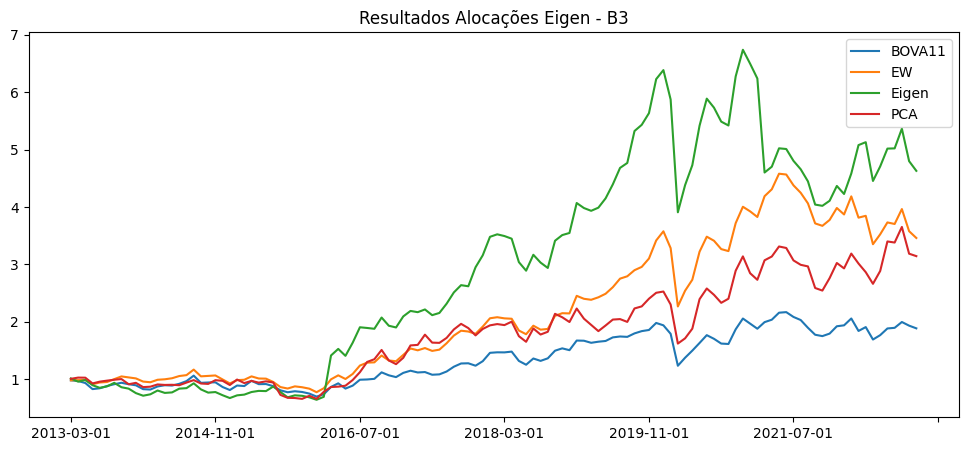

In [3]:
bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen = f.pipeline(stock_prices, periodos, oos, algo=f.weight_eigen);print('Eigen Done')
rets_pca = f.pipeline(stock_prices, periodos, oos, algo=f.weight_pca);print('PCA Done')

eigen_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen": rets_eigen['rets'],
        "PCA": rets_pca['rets'],
    }
)

rfr = f.annualize_rets(
    f.get_taxa_juros(rets_ew.index.min(),rets_ew.index.max())
)[0]



(1+eigen_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Eigen - B3");
f.summary_stats(eigen_portfolios_results, rfr)

In [4]:
eigen_portfolios_results.corr()

,BOVA11,EW,Eigen,PCA
BOVA11,1.000000,0.946018,0.655375,0.788090
EW,0.946018,1.000000,0.668204,0.848005
Eigen,0.655375,0.668204,1.000000,0.506769
PCA,0.788090,0.848005,0.506769,1.000000


## Saída LONG-ONLY

In [5]:
def weight_pca_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

def weight_eigen_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, pc_w = np.linalg.eigh(cov_matrix)
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

Eigen_long Done
PCA_long Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,6.67,23.13,-0.08503,-0.08585,0.02701,-9.48,-37.65,-0.74857,6.27378,11.07,14.51
EW,13.46,23.62,0.18278,0.17834,0.39640,-8.15,-36.60,-0.64811,6.27958,10.62,13.82
Eigen Long,13.04,25.06,0.15648,0.15307,0.36871,-8.92,-38.53,-0.70687,6.27257,11.46,15.07
PCA Long,13.41,24.88,0.17153,0.16757,0.40393,-9.25,-37.98,-0.68330,5.89234,11.35,14.07


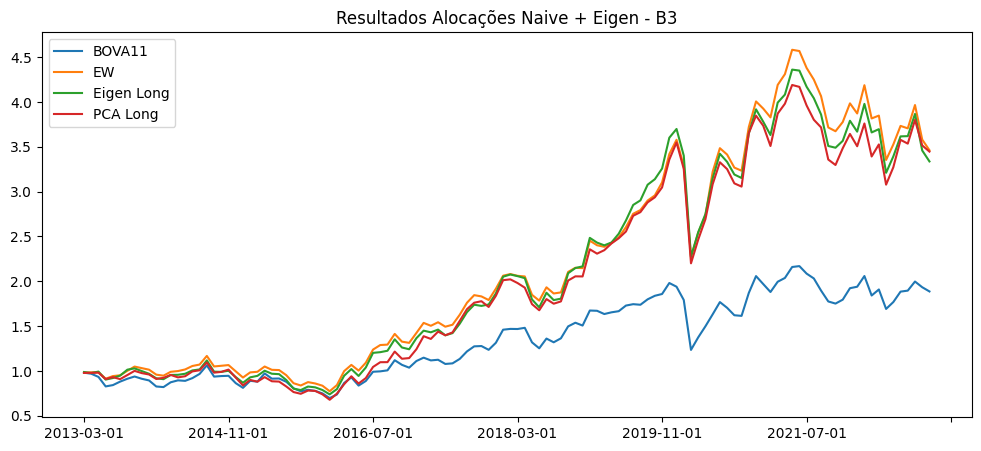

In [6]:
rets_eigen_long = f.pipeline(stock_prices, periodos, oos, algo=weight_eigen_long);print('Eigen_long Done')
rets_pca_long = f.pipeline(stock_prices, periodos, oos, algo=weight_pca_long);print('PCA_long Done')

eigen_long_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen Long": rets_eigen_long['rets'],
        "PCA Long": rets_pca_long['rets'],
    }
)

(1+eigen_long_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(eigen_long_portfolios_results, rfr)

## Demonstração dos Pesos Negativos e Extremos

In [7]:
from sklearn.decomposition import PCA
def weight_pca(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp/ pca_comp.sum()
    
    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normalize to sum to 1
    return res, cov_matrix.columns, stats

In [8]:
w, stocks, estat = weight_pca(stock_prices['2010':'2015'].dropna(axis='columns').pct_change().dropna(axis= 'rows'))
pesos_teste = pd.DataFrame(data={'stocks':stocks, 'pesos':w.round(6)*100})
pesos_teste.sort_values('pesos').head()

,stocks,pesos
50,STBP3.SA,-6.9180
30,GOAU4.SA,-5.5241
17,CYRE3.SA,-4.9585
3,B3SA3.SA,-4.6868
26,ETER3.SA,-4.4053


In [9]:
print(f'Resultado de todas as aloacações: {pesos_teste["pesos"].sum()}')
estat.head()

Resultado de todas as aloacações: 100.0


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
55,4.34,2.94,1.47432,1.46733,2.97681,-0.42,-2.43,-0.24774,2.38021,1.10,1.26
63,2.67,3.10,0.86248,0.83054,1.44150,-1.76,-5.58,-0.23844,3.08902,1.29,1.55
33,2.54,3.11,0.81602,0.75643,1.19010,-0.67,-3.37,-0.14264,4.93278,1.25,1.75
48,2.43,3.12,0.77851,0.71893,1.11808,-1.02,-4.19,-0.53544,3.27934,1.39,1.96
21,2.31,3.12,0.74035,0.76018,1.53784,-1.09,-4.78,0.09830,2.35839,1.26,1.43


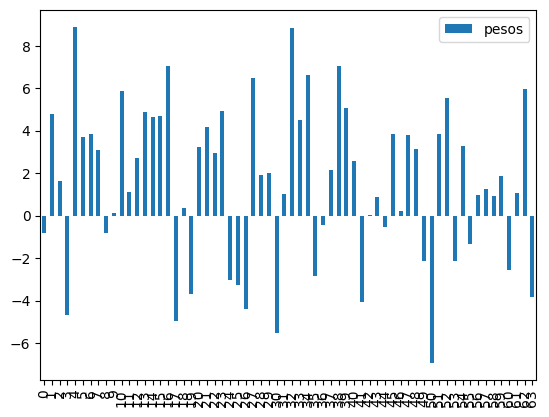

In [10]:
pesos_teste.plot.bar();